In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import seaborn as sns
import scipy.stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

/home/jasheu/.local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
df = pd.read_csv('tx_merged.csv')
df.head()

,Unnamed: 0,raw_row_number,date,time,location,lat,lng,district,substation,subject_age,...,vehicle_year,raw_race,raw_posted_speed,raw_actual_speed,raw_search_reason,raw_contraband_or_evidence,raw_custodial_arrest_made,make_model,age,price
0,0,27697,2012-11-15,09:55:00,7200 E IH 10,29.446583,-98.354972,4310.0,EAST,44.0,...,2007.0,W,-,-,NaN,NaN,NaN,2007.0 GMC 3500,15.0,8917.250000
1,1,27705,2012-11-15,11:20:00,7200 E IH 10,29.446583,-98.354972,4310.0,EAST,50.0,...,2006.0,H,-,-,NaN,NaN,NaN,2006.0 GMC 3500,16.0,7539.888889
2,2,648406|648407,2014-07-14,18:10:00,W HWY 90,29.388513,-98.673728,5340.0,WEST,24.0,...,2006.0,W,-,-,No Search,No,No,2006.0 GMC 3500,16.0,7539.888889
3,3,30690,2012-12-10,15:38:00,4100 S IH 37,29.379932,-98.457899,4220.0,EAST,54.0,...,2012.0,W,--,--,No Search,No,No,2012.0 CHRY 300,10.0,14623.444444
4,4,445794,2013-09-26,22:28:00,1000 NELOOP 410,29.520421,-98.489736,3320.0,NORTH,20.0,...,2012.0,W,--,--,No Search,No,No,2012.0 CHRY 300,10.0,14623.444444


In [3]:
df.columns

Index(['Unnamed: 0', 'raw_row_number', 'date', 'time', 'location', 'lat',
       'lng', 'district', 'substation', 'subject_age', 'subject_race',
       'subject_sex', 'type', 'violation', 'arrest_made', 'citation_issued',
       'outcome', 'contraband_found', 'search_conducted', 'search_basis',
       'speed', 'posted_speed', 'vehicle_color', 'vehicle_make',
       'vehicle_model', 'vehicle_registration_state', 'vehicle_year',
       'raw_race', 'raw_posted_speed', 'raw_actual_speed', 'raw_search_reason',
       'raw_contraband_or_evidence', 'raw_custodial_arrest_made', 'make_model',
       'age', 'price'],
      dtype='object')

In [4]:
# cheap: 0-10000
# midrange: 10000-40000
# expensive: 40000+
def bin_price(price):
    if price <= 10000:
        return 'cheap'
    elif price <= 35000:
        return 'mid'
    else:
        return 'expensive'

df['price_bin'] = df['price'].apply(bin_price)

In [89]:
price_grouped = df.groupby('price_bin').sum()
price_grouped_count = df.groupby('price_bin').count()
price_grouped['count'] = price_grouped_count['raw_row_number']
price_grouped['avg price'] = df.groupby('price_bin').mean()['price']
price_grouped = price_grouped[['count', 'arrest_made', 'citation_issued','search_conducted', 'avg price']]

In [90]:
price_grouped['arrest rate'] = price_grouped['arrest_made']/price_grouped['count'] *100

price_grouped['search rate'] = price_grouped['search_conducted']/price_grouped['count']*100
price_grouped

,count,arrest_made,citation_issued,search_conducted,avg price,arrest rate,search rate
price_bin,,,,,,,
cheap,27007,64,27007,208,6619.304058,0.236976,0.770171
expensive,3834,5,3834,10,58024.846512,0.130412,0.260824
mid,28542,32,28542,79,17853.098785,0.112115,0.276785


# CITATION RATE WRONG LOL 

In [7]:
df.groupby('substation').count()

,Unnamed: 0,raw_row_number,date,time,location,lat,lng,district,subject_age,subject_race,...,raw_race,raw_posted_speed,raw_actual_speed,raw_search_reason,raw_contraband_or_evidence,raw_custodial_arrest_made,make_model,age,price,price_bin
substation,,,,,,,,,,,,,,,,,,,,,
CENTRAL,6348,6348,6348,6348,6348,6348,6348,6348,6347,6346,...,6346,6348,6348,1391,1392,1339,6348,6348,6347,6348
EAST,9211,9211,9211,9211,9211,9211,9211,9211,9211,9210,...,9210,9211,9211,1062,1060,1038,9211,9211,9210,9211
NORTH,10614,10614,10614,10614,10614,10614,10614,10614,10614,10612,...,10612,10614,10614,1158,1158,1132,10614,10614,10613,10614
PRUE,10161,10161,10161,10161,10161,10161,10161,10161,10161,10161,...,10161,10161,10161,1343,1342,1320,10161,10161,10161,10161
SOUTH,14255,14255,14255,14255,14255,14255,14255,14255,14255,14249,...,14249,14255,14255,1184,1184,1148,14255,14255,14253,14255
WEST,8794,8794,8794,8794,8794,8794,8794,8794,8794,8792,...,8792,8794,8794,1017,1017,975,8794,8794,8792,8794


In [68]:
districts = df.groupby('district').sum()
districts_count = df.groupby('district').count()
districts['count'] = districts_count['raw_row_number']
districts['avg price'] = df.groupby('district').mean()['price']
districts = districts[['count', 'arrest_made', 'citation_issued','search_conducted', 'avg price']]


In [69]:
districts['arrest rate'] = districts['arrest_made']/districts['count'] *100
districts['citation rate'] = districts['citation_issued']/sum(districts['count'])*100
districts['search rate'] = districts['search_conducted']/districts['count']*100


In [70]:
districts.sort_values('avg price', ascending=False)

,count,arrest_made,citation_issued,search_conducted,avg price,arrest rate,citation rate,search rate
district,,,,,,,,
7260.0,2202,1,2202,4,18822.519083,0.045413,3.708132,0.181653
3310.0,482,1,482,2,18697.896281,0.207469,0.811680,0.414938
4120.0,1614,0,1614,1,18530.118694,0.000000,2.717950,0.061958
3170.0,399,1,399,1,18235.024436,0.250627,0.671909,0.250627
3370.0,61,1,61,4,18193.385723,1.639344,0.102723,6.557377
...,...,...,...,...,...,...,...,...
7110.0,88,2,88,3,10893.844766,2.272727,0.148191,3.409091
2350.0,108,1,108,7,10806.628836,0.925926,0.181870,6.481481
5250.0,175,0,175,1,10654.979743,0.000000,0.294697,0.571429


# FIX CITATION RATE, CORRELATE CAR PRICE AND STATS

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Search Rate In Each District')

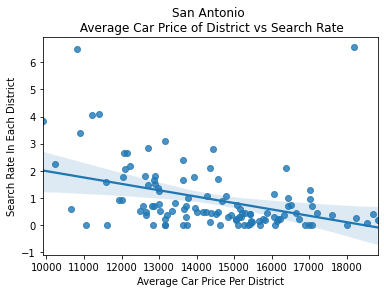

In [85]:
p = sns.regplot(districts['avg price'], districts['search rate'])
p.set(title='San Antonio \n Average Car Price of District vs Search Rate')
p.set_xlabel('Average Car Price Per District')
p.set_ylabel('Search Rate In Each District')


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Arrest Rate In Each District')

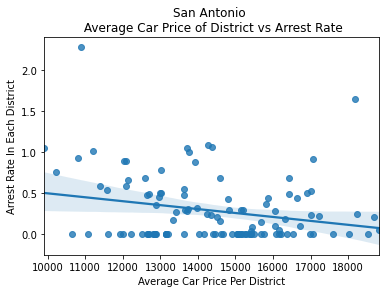

In [86]:
p = sns.regplot(districts['avg price'], districts['arrest rate'])
p.set(title='San Antonio \n Average Car Price of District vs Arrest Rate')
p.set_xlabel('Average Car Price Per District')
p.set_ylabel('Arrest Rate In Each District')


In [13]:
race = df.groupby('subject_race').sum()
race_count = df.groupby('subject_race').count()
race['count'] = race_count['raw_row_number']
race['avg price'] = df.groupby('subject_race').mean()['price']
race = race[['count', 'arrest_made', 'citation_issued','search_conducted', 'avg price']]
race = race.reset_index()
race

,subject_race,count,arrest_made,citation_issued,search_conducted,avg price
0,asian/pacific islander,918,0,918,0,15238.674113
1,black,5838,13,5838,44,13147.395639
2,hispanic,30972,50,30972,154,14613.640179
3,other,1733,0,1733,5,14880.936691
4,unknown,39,0,39,0,13287.181600
5,white,25703,39,25703,107,16812.132795


<AxesSubplot:xlabel='subject_race', ylabel='avg price'>

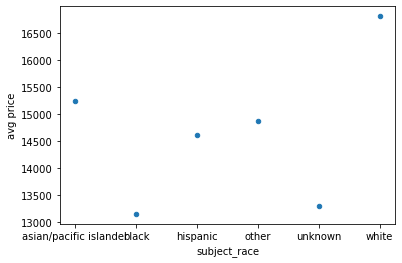

In [14]:
race.plot.scatter('subject_race', 'avg price')

price relative to census area
is car stopped in area on average more expensive or less expensive


In [15]:
open_sa = "tx_merged.csv"
open_data = pd.read_csv(open_sa)

census_file = "nhgis0005_ds239_20185_blck_grp.csv"
census_df = pd.read_csv(census_file)

use = ['GISJOIN','COUNTY','AJZAE001']
census_df = pd.read_csv(census_file, usecols = use)
# Bexar County is San Antonio
census_df = census_df.loc[census_df['COUNTY'] == 'Bexar County']
#census_df


url = "TX_blck_grp_2018.shx"
census_gdf = geopandas.read_file(url)
census_shape = census_gdf[['GISJOIN','geometry']]

census_shape['GISJOIN'] = census_shape['GISJOIN'].str.slice(stop = 15)

census_joined = census_shape.merge(census_df, on = 'GISJOIN')
census_joined = census_joined.to_crs(epsg = 2230)

/home/jasheu/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<AxesSubplot:>

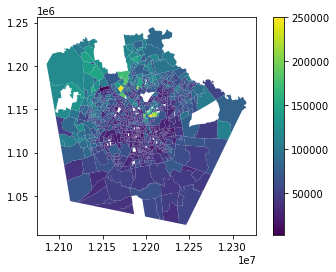

In [16]:
census_joined.plot(column = 'AJZAE001', legend
                   = True)


In [17]:
gdf = geopandas.GeoDataFrame(open_data, geometry=geopandas.points_from_xy(open_data['lng'], open_data['lat']))
gdf = gdf.loc[(gdf['lng'].isna()) == False]
gdf = gdf.loc[(gdf['lat'].isna()) == False]
gdf = gdf.set_crs(epsg = 4326)
gdf = gdf.to_crs(epsg = 2230)

In [18]:
join_df = gdf.sjoin(census_joined, how="inner")

In [19]:
substations = join_df.loc[join_df['substation'].isna()==False]

In [20]:
df = substations

In [21]:
sub = df.groupby('district').sum()
sub_count = df.groupby('district').count()
sub['count'] = sub_count['raw_row_number']
sub['avg price'] = df.groupby('district').mean()['price']
sub['avg income'] = df.groupby('district').mean()['AJZAE001']
sub = sub[['count', 'arrest_made', 'citation_issued','search_conducted', 'avg price', 'avg income']]
sub = sub.reset_index()


sub['arrest rate'] = sub['arrest_made']/sub['count'] *100
sub['search rate'] = sub['search_conducted']/sub['count']*100


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Average Income of District vs Arrest Rate')]

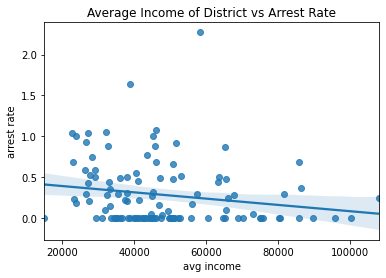

In [22]:
sns.regplot(sub['avg income'], sub['arrest rate']).set(title='Average Income of District vs Arrest Rate')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Average Income of District vs Search Rate')]

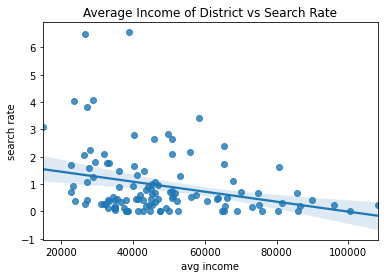

In [23]:
sns.regplot(sub['avg income'], sub['search rate']).set(title='Average Income of District vs Search Rate')

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Average Income of District vs Average Car price')]

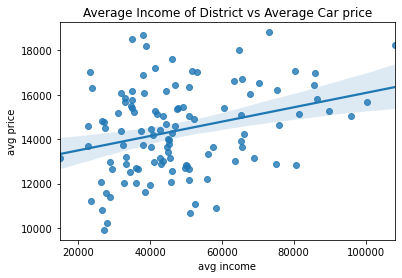

In [24]:
sns.regplot(sub['avg income'], sub['avg price']).set(title='Average Income of District vs Average Car price')

In [25]:
districts = list(df['district'].unique())


In [26]:
df.where(df['district'] == districts[0]).dropna(how='all')[[]]

""
0
1
118
261
289
...
33453
36601
38646
50622


In [27]:
sub[['search rate', 'avg price']].corr()

,search rate,avg price
search rate,1.000000,-0.390211
avg price,-0.390211,1.000000


# Log Reg

In [28]:
lr_df = df[['search_conducted','price','age', 'AJZAE001']].dropna()

X = lr_df[['price','age', 'AJZAE001']].to_numpy()
y = (lr_df['search_conducted'] * 1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [29]:
logistic_reg = LogisticRegression().fit(X_train,y_train)
print(logistic_reg.coef_, logistic_reg.intercept_)

[[-1.89897252e-04 -1.14491220e-01 -3.99927555e-05]] [-0.00784988]


In [30]:
preds = logistic_reg.predict(X_test)

In [31]:
total = 0
for i, j in zip(y_test, preds):
    if i == j:
        total += 1
total/ len(y)
    

0.32846639384060483

In [32]:
lr_df = df[['search_conducted','price','age', 'AJZAE001']].dropna()
lr_df['poly'] = lr_df['price'] * lr_df['AJZAE001']
X = lr_df[['price','age', 'AJZAE001', 'poly']].to_numpy()
y = (lr_df['search_conducted'] * 1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
logistic_reg = LogisticRegression().fit(X_train,y_train)
print(logistic_reg.coef_, logistic_reg.intercept_)

[[-1.80935904e-05 -9.32541934e-08 -1.26282810e-04 -8.63846169e-10]] [-5.4705459e-09]


In [33]:
log_reg = sm.Logit(y_train, X_train).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.032688
         Iterations 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                38637
Model:                          Logit   Df Residuals:                    38633
Method:                           MLE   Df Model:                            3
Date:                Sun, 06 Mar 2022   Pseudo R-squ.:                -0.03925
Time:                        11:01:00   Log-Likelihood:                -1263.0
converged:                       True   LL-Null:                       -1215.3
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0003   1.89e-05    -15.272      0.000      -0.000      -0.000
x2            -0.0796      0.010     -8.026      0.000      -0.099      -0.060
x3          -5.32e-05   3.71e-06    -14.328      0.000   -6.05e-05   -4.59e-05
x4          2.473e-09   1.58e-10     15.608      0.000    2.16e-09    2.78e-09
==============================================================================
"""

In [49]:
df['arrest_made']

0        False
1        False
118      False
261      False
289      False
         ...  
59129    False
59449    False
59975    False
60619    False
63837    False
Name: arrest_made, Length: 59383, dtype: bool

In [51]:
lr_df = df[['arrest_made','price','age', 'AJZAE001']].dropna()
lr_df['poly'] = lr_df['price'] * lr_df['AJZAE001']
X = lr_df[['price','age', 'AJZAE001', 'poly']].to_numpy()
y = (lr_df['arrest_made'] * 1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
logistic_reg = LogisticRegression().fit(X_train,y_train)
print(logistic_reg.coef_, logistic_reg.intercept_)


[[-2.70743215e-05 -1.48639099e-07 -1.82840691e-04  3.99286213e-10]] [-8.41922711e-09]


In [52]:
log_reg = sm.Logit(y_train, X_train).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.012690
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                38637
Model:                          Logit   Df Residuals:                    38633
Method:                           MLE   Df Model:                            3
Date:                Sun, 06 Mar 2022   Pseudo R-squ.:                -0.07883
Time:                        12:17:12   Log-Likelihood:                -490.30
converged:                       True   LL-Null:                       -454.47
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0003      3e-05     -9.141      0.000      -0.000      -0.000
x2            -0.1374      0.018     -7.506      0.000      -0.173      -0.102
x3         -6.488e-05   7.17e-06     -9.047      0.000   -7.89e-05   -5.08e-05
x4          2.362e-09   2.46e-10      9.585      0.000    1.88e-09    2.84e-09
==============================================================================
"""

To interpret regression: 

are my coeff significant? calculate standard errors

1. use scikit and calculate stats (STD, mean), calculate standard error and pvalues by hand
2. use stats models (logistic regression in stats models) 

https://www.statsmodels.org/stable/index.html 

plots:

3. car prices one axis, income another axis, size of dot is search rate (bin the data) 
4. matrix plot

regression again: 

5. throw in all the data, including income, value, using log reg, see which variables have most impact (age, time of day) see which variables are strongest, use stats models to see which ones are significant
6. do stats models controlling for a certain var (income etc)

In [34]:
sub

,district,count,arrest_made,citation_issued,search_conducted,avg price,avg income,arrest rate,search rate
0,2110.0,1383,2,1383,2,15670.789897,33156.629790,0.144613,0.144613
1,2120.0,768,4,768,10,17014.295953,53040.625000,0.520833,1.302083
2,2130.0,209,1,209,1,12652.943931,50872.703349,0.478469,0.478469
3,2140.0,279,0,279,1,12659.226837,36653.917563,0.000000,0.358423
4,2150.0,464,0,464,2,14395.082846,42803.144397,0.000000,0.431034
...,...,...,...,...,...,...,...,...,...
110,7330.0,122,0,122,2,12855.664122,80683.688525,0.000000,1.639344
111,7340.0,3885,2,3885,9,16153.997891,44560.554183,0.051480,0.231660
112,7350.0,275,0,275,0,16997.994416,85994.930909,0.000000,0.000000
113,7360.0,438,3,438,3,16432.671359,85778.616438,0.684932,0.684932


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No handles with labels found to put in legend.


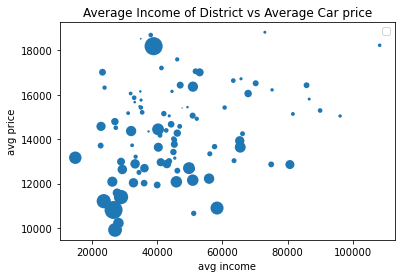

In [60]:
sns.scatterplot(sub['avg income'], sub['avg price'], s=sub['search rate'] *50).set(title='Average Income of District vs Average Car price')
plt.legend()

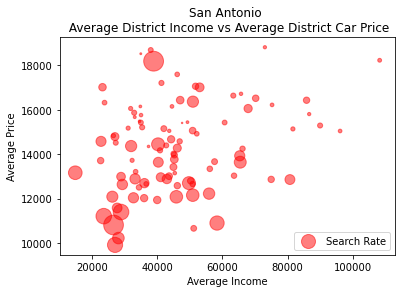

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig0 = sub.plot.scatter(x = 'avg income', y = 'avg price', s=sub['search rate']*60, alpha=0.5, ax = axes, color='red')

fig0.set_title('San Antonio \n Average District Income vs Average District Car Price')

fig0.set_xlabel('Average Income')
fig0.set_ylabel('Average Price')

axes.legend(['Search Rate']);


In [36]:
def get_bin_search_rate(group):
    return price_grouped['search rate'][group]

In [53]:
df['price_bin'] = df['price'].apply(bin_price)
df['binned search rate'] = df['price_bin'].apply(get_bin_search_rate)
df['income'] = df['AJZAE001']

/home/jasheu/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


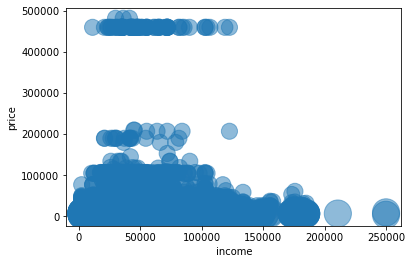

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig0 = df.plot.scatter(x = 'income', y = 'price', s=df['binned search rate'] *1000, alpha=0.5, ax = axes)


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


ValueError: s must be a scalar, or float array-like with the same size as x and y

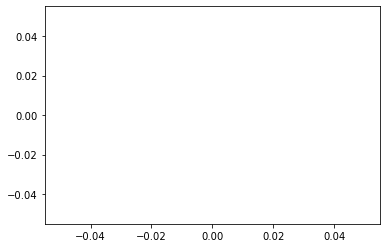

In [38]:
sns.scatterplot(df['AJZAE001'], df['price'], s=df['binned search rate']).set(title='Average Income of District vs Average Car price')

In [ ]:
df.columns

In [ ]:
sns.pairplot(df[['age','price','income', 'binned search rate', 'price_bin']], hue='price_bin', diag_kind='auto')